# Core Competencies of Ericksonian Therapy

This notebook describes the preparation of the *Core Competencies* multilingual [dataset](https://huggingface.co/datasets/LoneWolfgang/ericksonian-core-competencies-multilingual).

The *Core Competencies* is a training manual that explores the history and methodology of Ericksonian therapy. The original [English](https://iamdrshort.com/New_Papers/Core%20Competencies%20Manual%20R-2019.pdf) version has been translated into four languages:
 - [French](https://iamdrshort.com/New_Papers/Manuel%20des%20comp%C3%A9tences%20fondamentales%20en%20hypnose%20ericksonienne.pdf)
 - [Italian](https://iamdrshort.com/New_Papers/CCET_Italiano.pdf)
 - [Portuguese](https://iamdrshort.com/New_Papers/Princ%C3%ADpios%20e%20Compet%C3%AAncias%20Fundamentais%20da%20Terapia%20Ericksoniana%20(Primeira%20vers%C3%A3o).pdf)
 - [Spanish](https://iamdrshort.com/New_Papers/CCETl_ESPANOL.pdf)

The manual has also been translated into [Indonesian](https://iamdrshort.com/New_Papers/CC_Indonesian_Translation.pdf). However, unlike the other translations, the Indonesian manual reorganizes the material and introduces original content. It remains to be seen whether portions of this version align more closely at the sentence level. Future updates may include Indonesian data.

## Setup

To follow along, you will need to install the purpose built Python package, `docutrance`. This will install depencies and some custom objects.

```
pip install docutrance
```

## Outline

This notebook is divided into three sections:

- **Section Alignment**  
  This section explains how content and headers were manually extracted from the raw material and organized into a structured corpus JSON file.

- **Sentence Alignment**  
  This section describes how a multilingual sentence embedder was used to automatically align sentences across languages, proceeding section by section.

- **Evaluation**  
  This section outlines the contents of the dataset and highlights current shortcomings that may need to be addressed in downstream tasks.

## Section Alignment

The *Core Competencies* manual was translated by teams of native speakers with expertise in Ericksonian therapy. Efforts were made to closely follow the structure of the original English version. However, natural differences in discourse structure across languages entail some divergence in sentence and paragraph organization. As a result, even high-quality translations require context-aware methods for accurate sentence alignment.

To align sentences, we will use a multilingual SBERT model to encode and compare sentences via cosine similarity. Notably, the same model used for alignment will eventually be finetuned during training. This approach carries some risk: if the initial model produces poor alignments, its biases will persist through training. To mitigate this, we will leverage the document structure. Between translations, chapters and sections are perfectly aligned. Thus, sentence alignment will proceed section by section. This approach not only improves accuracy by narrowing the alignment context but also reduces memory usage.

The contents of the *Core Competencies* were manually extracted and structured into into JSON:
```
{
    "section_id": {
        "language": {
            "header": "...",
            "content": "..."
        },
        ...
    },
}
```

 - **section_id**: A string identifier representing the chapter and section (e.g., "1-1", "2-3)
 - **language**: An ISO 639-1 language code—either 'en', 'fr', 'it', 'pt', or 'es'.
 - **header**: The section header extracted from the source document.
 - **contenut**: The full text content of the corresponding section.

In [1]:
from pathlib import Path
import json
import random


path = '../data/corpora/core_competencies.json'
load_json = lambda path: json.loads(Path(path).read_text())

corpus = load_json(path)

sections = list(corpus.keys())
langs = list(corpus[sections[0]].keys())
sample = random.choice(sections), random.choice(langs)

print("Sections:", sections, '\n')
print("Languages:", langs, '\n')
print(f"Entry for Section {sample[0]}, Language {sample[1]}:\n")
print(json.dumps(corpus[sample[0]][sample[1]], indent=2, ensure_ascii=False))

Sections: ['0-1', '0-2', '0-3', '0-4', '1-1', '1-2', '1-3', '1-4', '1-5', '2-1', '2-2', '2-3', '2-4', '2-5', '3-1', '3-2', '3-3', '3-4', '3-5', '3-6', '3-7', '4-1', '4-2', '4-3', '5-1', '5-2', '5-3'] 

Languages: ['en', 'es', 'fr', 'it', 'pt'] 

Entry for Section 3-4, Language fr:

{
  "header": "STRATÉGIQUE : Disposition à créer un contexte de résolution de problèmes autoorganisé",
  "content": "En plus de souligner l’importance d’accepter le caractère unique de chaque individu, la T. E. reconnaît également la conception innée des êtres humains en tant que créatures auto-organisées ou « bâtisseurs de vie ». Erickson pensait que les êtres humains étaient des organismes orientés vers la survie et la croissance, avec un besoin inné de maîtriser les expériences internes et externes de la vie. Il s’efforce donc de surmonter les obstacles et les défis tout en s’appuyant sur des connaissances organiques et sur l’apprentissage de toute une vie. Par conséquent, la T. E. part du principe que to

## Sentence Alignment

To perform sentence alignment, we first need to split paragraphs into individual sentences. However, sentence tokenization is not language-agnostic. Different languages require different rules and models to tokenize correctly. 

To handle this, we use a set of language-optimized tokenizers trained by [spaCy](https://spacy.io/universe/project/spacy-udpipe) as part of the Universal Dependencies (UD) project. These UD-based tokenizers are lightweight and performant when the language is explicitly defined.

To simplify the implementation, we use the class **`docutrance.preprocess.UDSentenceTokenizer`**. Given a list of languages, this class automatically downloads the necessary language models and stores the tokenizers in memory for reuse.

In [ ]:
from docutrance.preprocess import UDSentenceTokenizer

paragraphs = {
    "en": "Hello World. How are you?",
    "es": "Hola mundo. ¿Cómo estás?",
    "fr": "Bonjour tout le monde. Comment allez-vous?",
    "it": "Ciao mondo. Come stai?",
    "pt": "Olá, mundo. Como você está?"
}

languages = list(paragraphs.keys())
tokenizer = UDSentenceTokenizer(languages)

sentences = {k: tokenizer.tokenize(k, v) for k,v in paragraphs.items()}

print()
for lang, sents in sentences.items():
    print(f'{lang}:', sents)

Initializing UD Tokenizer for ['en', 'es', 'fr', 'it', 'pt']. . .
Already downloaded a model for the 'en' language
Already downloaded a model for the 'es' language
Already downloaded a model for the 'fr' language
Already downloaded a model for the 'it' language
Already downloaded a model for the 'pt' language

en: ['Hello World.', 'How are you?']
es: ['Hola mundo.', '¿Cómo estás?']
fr: ['Bonjour tout le monde.', 'Comment allez-vous?']
it: ['Ciao mondo.', 'Come stai?']
pt: ['Olá, mundo.', 'Como você está?']


To align sentences, we use the best-performing multilingual model from [SBERT](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2).

The function **`docutrance.preprocess.align_sentences`** takes three arguments: `source_sentences`, `target_sentences`, and `model`.

1. The model encodes both the source and target sentences into dense vector representations.
2. A cosine similarity matrix is computed between each pair of source and target sentences.
3. For each source sentence, the function selects the best-matching target sentence along with its similarity score.

In [ ]:
from docutrance.preprocess import align_sentences
from sentence_transformers import SentenceTransformer
import pandas as pd
import random

languages = list(sentences.keys())
source, target = random.sample(languages, 2)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

print(f"Matching {source} to {target}")
pd.DataFrame.from_dict(align_sentences(
    sentences[source],
    sentences[target],
    model
))

Matching en to it


,source,target,score
0,Hello World.,Ciao mondo.,0.982399
1,How are you?,Come stai?,0.979604


The function **`docutrance.preprocess.align_sentences_process`** is hard-coded for  corpus structure defined in this notebook. It processes the data section by section and language by language, producing a separate dataframe for each section–language pair. Once all subsets are processed, the intermediate dataframes are concatenated into a single final output.

The function takes two arguments:

- **`io_paths`**: A dictionary containing paths for the input corpus and the final output file.
- **`model`**: A multilingual sentence embedding model used to align sentences between languages.


In [332]:
from docutrance.preprocess import align_sentences_process
from sentence_transformers import SentenceTransformer
from pathlib import Path

data = Path('../data')

io_paths = {
    "corpus": data / "corpora" / "core_competencies.json",
    "output": data / "tables" / "core_competencies.parquet"
}

model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')


align_sentences_process(
    io_paths,
    model
)

Initializing UD Tokenizer for ['en', 'es', 'fr', 'it', 'pt']. . .
Already downloaded a model for the 'en' language
Already downloaded a model for the 'es' language
Already downloaded a model for the 'fr' language
Already downloaded a model for the 'it' language
Already downloaded a model for the 'pt' language
Section 0-1, en-es is already finished. Continuing. . . 
Section 0-1, en-fr is already finished. Continuing. . . 
Section 0-1, en-it is already finished. Continuing. . . 
Section 0-1, en-pt is already finished. Continuing. . . 
Section 0-2, en-es is already finished. Continuing. . . 
Section 0-2, en-fr is already finished. Continuing. . . 
Section 0-2, en-it is already finished. Continuing. . . 
Section 0-2, en-pt is already finished. Continuing. . . 
Section 0-3, en-es is already finished. Continuing. . . 
Section 0-3, en-fr is already finished. Continuing. . . 
Section 0-3, en-it is already finished. Continuing. . . 
Section 0-3, en-pt is already finished. Continuing. . . 
Secti

## Evaluation

Now the the sentences have been aligned, the final steps are to evaluate the data and identify shortcomings that need to be adressed before training.

### Santity Check

Start by loading the data and exploring its contents.

In [199]:
#Loads the processed dataframe and prints the first five rows.
import pandas as pd


results = '../data/tables/core_competencies.parquet'
df = pd.read_parquet(results)
df.head(5)

,section_id,target_language,english_header,english_sentence,non_english_header,non_english_sentence,similarity_score
0,0-1,es,Introduction to the Core Competencies Manual o...,The Ericksonian approach to therapy represents...,Introduzione al Manuale per le Competenze Chia...,"El abordaje terapéutico Ericksoniano, represen...",0.955194
1,0-1,es,Introduction to the Core Competencies Manual o...,People who identify themselves as being an Eri...,Introduzione al Manuale per le Competenze Chia...,Personas que se identifican a sí mismos siendo...,0.900950
2,0-1,es,Introduction to the Core Competencies Manual o...,"The Milton H. Erickson Foundation, Inc. was in...",Introduzione al Manuale per le Competenze Chia...,La fundación M. Erickson fue creada el 29 de O...,0.795812
3,0-1,es,Introduction to the Core Competencies Manual o...,"To this end, the Foundation provides ongoing e...",Introduzione al Manuale per le Competenze Chia...,"Desde Milton Erickson hasta la fecha, la Funda...",0.854311
4,0-1,es,Introduction to the Core Competencies Manual o...,In addition to the work of the Erickson Founda...,Introduzione al Manuale per le Competenze Chia...,Se agrega al trabajo de la Fundación de Ericks...,0.970191


In [200]:
#Selects a random example from each language subset and prints the contents.

import random
pprint = lambda idx, column: print(f"{column}: {df.loc[idx, column]}")

for lang, subset in df.groupby('target_language'):
    sample = random.choice(df.index)
    print(f"en-{lang}")
    for column in ["english_header", "non_english_header", "english_sentence", "non_english_sentence", "similarity_score"]:
        pprint(sample, column)
    print()
    

en-es
english_header: ADDITIONAL RESOUCES
non_english_header: RESSOURCES COMPLEMENTAIRES
english_sentence: An effort has been made to provide precise definitions for any term that appears in this manual.
non_english_sentence: Un effort a été fait afin de fournir de les définitions précises pour tout terme apparaissant dans ce manuel.
similarity_score: 0.9137794971466064

en-fr
english_header: Glossary of Ericksonian Terminology
non_english_header: GLOSSAIRE DE LA TERMINOLOGIE ÉRICKSONIENNE
english_sentence: An experiential exercise during which the client dissociates from the symptom or problem behavior by engaging it as an entity separate from the self.
non_english_sentence: Extériorisation — Exercice expérientiel à le cours de lequel le client se dissocie de le symptôme ou de le comportement problématique en le considérant comme une entité distincte de lui-même.
similarity_score: 0.8339834213256836

en-it
english_header: History of the Milton H. Erickson Foundation: A Story of Cooper

One consideration in the confidence level in sentence matching, approximated by the similarity score. Most sentences are matched with relatively high confidence. When grouped by similarity score, most sentences pairs had a score that exceeded 0.9, signifying close alignment. Almost 75% of pairs had a score above 0.8, and pairs less than 0.5 were an outlying minority:

         similarity_score
-----  ------------------
count         7379
mean             0.847177
std              0.132552
min              0.175458
25%              0.781014
50%              0.895158
75%              0.947546
max              1


array([[<Axes: title={'center': 'similarity_score'}>]], dtype=object)

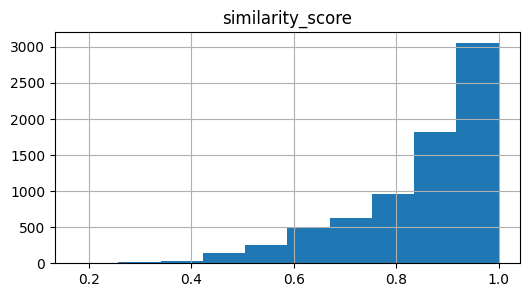

In [201]:
from tabulate import tabulate

print(tabulate(df.describe(), headers='keys'))
df.hist('similarity_score', bins=10, figsize=(6, 3))

While the majority of the data is in good shape, some rows require cleaning to ensure overall quality. Four problematic features were addressed using heuristic methods: `mismatched sentence lengths`, `underlength sentences`, `misaligned sentences`, and `overlength sentences`.

## Mismatched Sentence Lengths

Differences in formatting and tokenizer behavior between the original document and its translations led to inconsistent sentence segmentation. Beyond a certain threshold, these inconsistently segmented sentences no longer make viable training pairs.

To quantify this, the `relative length difference` is calculated by dividing the absolute difference in token sequence lengths by their average. This normalization magnifies length mismatches in shorter sequences and diminishes them in longer ones.

The working hypothesis is that a larger relative length difference indicates poor sentence alignment. Accordingly, the quality of the training data is assessed by progressively removing sentence pairs with increasingly large relative length differences.

The following code block plots and tabulates how the average `similarity_score` changes as examples exceeding various thresholds are filtered out. The table also shows the corresponding drop in data retention under stricter thresholds:

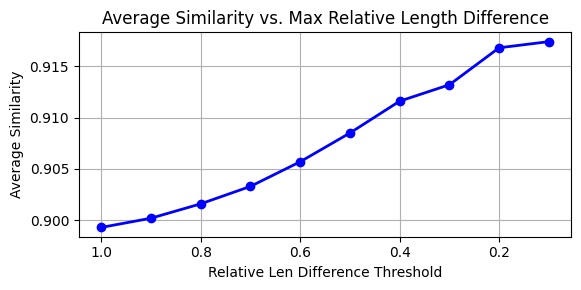

| Max Relative Len Diff   |   Avg Similarity |   Data Retained (%) |
|-------------------------|------------------|---------------------|
| -                       |           0.8789 |              100    |
| 1.0                     |           0.8993 |               90.56 |
| 0.9                     |           0.9002 |               89.99 |
| 0.8                     |           0.9016 |               89.09 |
| 0.7                     |           0.9033 |               88.15 |
| 0.6                     |           0.9057 |               86.49 |
| 0.5                     |           0.9085 |               84.04 |
| 0.4                     |           0.9116 |               80.16 |
| 0.3                     |           0.9132 |               74.36 |
| 0.2                     |           0.9168 |               60.01 |
| 0.1                     |           0.9174 |               34.91 |


In [309]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Callable

def drop_duplicates(df: pd.DataFrame):
    for column in ["english_sentence", "non_english_sentence"]:
        df.drop_duplicates(subset=['target_language', column], inplace=True)
    return df

def get_token_columns(
    df: pd.DataFrame,
    input_columns: List[str] = ["english_sentence", "non_english_sentence"],
    output_columns: List[str] = ["english_tokens", "non_english_tokens"],
    tokenize_fn = lambda x: x.split()
) -> pd.DataFrame:
    """Tokenizes sentence columns in a DataFrame using a specified tokenization function."""
    for input_col, output_col in zip(input_columns, output_columns):
        df[output_col] = df[input_col].apply(tokenize_fn)
    return df

def compute_relative_diff(value1, value2):
    """Normalizes the difference between two values by dividing by the mean value."""
    return abs(value1 - value2) / ((value1 + value2) / 2) if (value1 + value2) != 0 else 0

def get_relative_len_diff_column(
        df: pd.DataFrame,
        input_columns: list[str] = ["english_tokens", "non_english_tokens"],
        output_column: str = "relative_len_diff"
):
    """Adds a column for relative length difference of two tokens lists."""
    df[output_column] = df[input_columns].apply(
        lambda row: compute_relative_diff(len(row[input_columns[0]]), len(row[input_columns[1]])),
        axis=1
    )
    return df

def filter_by_token_length(
    df: pd.DataFrame,
    token_columns: List[str] = ["english_tokens", "non_english_tokens"],
    max_length: int = 128
) -> pd.DataFrame:
    """
    Filters rows where both tokenized sequences are less than or equal to max_length.
    Adds helper columns with sequence lengths and returns filtered DataFrame.
    """
    for col in token_columns:
        length_col = f"{col}_length"
        df[length_col] = df[col].apply(len)

    length_cols = [f"{col}_length" for col in token_columns]
    condition = (df[length_cols[0]] <= max_length) & (df[length_cols[1]] <= max_length)

    return df[condition]

def sentence_id_fn(df):
    original_columns = list(df.columns)
    results = []

    # Get unique sentence rows
    unique = df[['section_id', 'english_sentence']].drop_duplicates()

    # Group by section
    for section_id, subset in unique.groupby('section_id'):
        subset = subset.reset_index(drop=True)
        subset['sentence_id'] = [f"{section_id}-{str(i).zfill(3)}" for i in range(len(subset))]
        results.append(subset)

    results = pd.concat(results, ignore_index=True)
    merged = df.merge(results, how='left', on=['section_id', 'english_sentence'])
    merged = merged[['sentence_id'] + original_columns]
    return merged

def load_and_preprocess(
        path,
        max_relative_len_diff: float=None, 
        min_sequence_len: int=None,
        min_similarity: float=None,
        model: SentenceTransformer=None,
        max_sequence_len: int=None,
        remove_intermediate_columns: bool=False,
        assign_sentence_ids: bool=False
):
    
    df = pd.read_parquet(path)
    original_columns = df.columns

    df = drop_duplicates(df)
    df = get_token_columns(df)
    df = get_relative_len_diff_column(df)
    if max_relative_len_diff:
        df = df[df.relative_len_diff <= max_relative_len_diff]
    if min_sequence_len:
        df = df[df.english_tokens.apply(lambda x: len(x) >= min_sequence_len)]
    if min_similarity:
        df = df[df.similarity_score >= min_similarity]
    if model and max_sequence_len:
        tokenize_fn = lambda x: model.tokenizer.tokenize(x)
        df = get_token_columns(df, tokenize_fn=tokenize_fn)
        df = filter_by_token_length(df, max_length=max_sequence_len)
    if remove_intermediate_columns:
        df = df[original_columns]
    if assign_sentence_ids:
        df = sentence_id_fn(df)

    return df

def plot_and_tabulate_length_diff(
        df: pd.DataFrame,
        thresholds: list = [n * 0.1 for n in range(10, 0, -1)],
        x_column = "relative_len_diff",
        y_column = "similarity_score",
        figsize = (6, 3)
):
    """Main function that processes, tabulates, and plots change in average similarity over a range of maximum relative sequence length difference."""
    df = get_token_columns(df)
    df = get_relative_len_diff_column(df)

    # Initiate an empty list of rows for the final summary table
    rows = []

    # First row: Baseline stats for the whole dataset
    overall_avg = df[y_column].mean()
    rows.append({
        "Max Relative Len Diff": "-",
        "Avg Similarity": round(overall_avg, 4),
        "Data Retained (%)": 100.00
    })

    # Remaining rows: Threshold-based stats
    total_rows = len(df)
    for threshold in thresholds:
        filtered = df[df[x_column] < threshold]
        avg_similarity = filtered[y_column].mean()
        retention = len(filtered) / total_rows * 100  

        rows.append({
            "Max Relative Len Diff": round(threshold, 2),
            "Avg Similarity": round(avg_similarity, 4),
            "Data Retained (%)": round(retention, 2)
        })

    summary_table = pd.DataFrame(rows)

    # Plot similarity (skip the baseline row with "-")
    plot_data = summary_table[summary_table["Max Relative Len Diff"] != "-"]


    plt.figure(figsize=figsize)
    plt.plot(
        plot_data['Max Relative Len Diff'],
        plot_data['Avg Similarity'],
        marker='o',
        color='blue',
        linewidth=2
    )
    plt.title('Average Similarity vs. Max Relative Length Difference')
    plt.xlabel('Relative Len Difference Threshold')
    plt.ylabel('Average Similarity')
    plt.grid(True)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

    # Display table
    print(tabulate(summary_table, headers='keys', tablefmt='github', showindex=False))
    return df

results = '../data/tables/core_competencies.parquet'
df = load_and_preprocess(results)

df = plot_and_tabulate_length_diff(df)


The plot and table illustrate how average similarity and data retention change as sentence pairs exceeding a length difference threshold are progressively excluded.

Applying a threshold of **1.0** already results in a **3-point increase** in average similarity. As the threshold becomes more restrictive, the quality of sentence alignments continues to improve.

However, this comes at a cost—**data retention drops sharply** once the threshold falls below **0.5**.

## Underlength Sentences

During tokenization, some formatting artifacts, such as list markers, page dividers, and common headings, were extracted as standalone sentences. These segments are often paired incorrectly, despite recieving a relatively high similarity score. Even when correctly aligned, these minimal fragments are usually trivial for the baseline model to interpret, making them uninformative for training.

The following code block displays examples with 1 to 5 tokens, illustrating how sequence quality improves once a minimum length threshold is enforced:

In [262]:
def pprint(df):
    print(tabulate(df[[
    'english_sentence', 
    'non_english_sentence',
    'similarity_score']].sample(5), headers= 'keys', showindex=False, tablefmt='github'))

# Load the DataFrame with token lists and the relative length differences.
results = '../data/tables/core_competencies.parquet'
df = load_and_preprocess(
    results,
    max_relative_len_diff=0.5)

for n in [1, 5]:
    print(f"Examples with {n} tokens:")
    print()
    pprint(df[df.english_tokens.apply(lambda x: len(x) == n)])
    print()

Examples with 1 tokens:

| english_sentence   | non_english_sentence   |   similarity_score |
|--------------------|------------------------|--------------------|
| •                  | ).                     |           0.803156 |
| II.                | II.                    |           1        |
| VI.                | III.                   |           0.655262 |
| Reliability        | Confiabilidade         |           0.856927 |
| II.                | II.                    |           1        |

Examples with 5 tokens:

| english_sentence                               | non_english_sentence                                                  |   similarity_score |
|------------------------------------------------|-----------------------------------------------------------------------|--------------------|
| (Also referred to as: Surprise).               | (Également appelé : recentrage).                                      |           0.563681 |
| Operational Examples of Strategi

## Misaligned Sentences

Sentence pairs with similarity scores below a certain threshold are likely to be misaligned and should be withheld from training. However, this must be done with care. While correctly aligned pairs with high similarity scores help anchor the model to the ground truth, they offer limited learning value. In contrast, correctly aligned pairs with low similarity scores represent the best opportunity for the model to learn novel or difficult relationships.

For this iteration, a minimum similarity threshold of 0.7 was heuristically chosen. In a future update, this dataset will undergo human review to validate alignments and refine threshold selection.

In [ ]:
results = '../data/tables/core_competencies.parquet'
df = load_and_preprocess(
    results,
    max_relative_len_diff=0.5,
    min_sequence_len=5)

for n in [0.5, 0.6, 0.7]:
   for _, row in df[df.similarity_score.between(n, n+0.1)].sample(1).iterrows():
      print("Score:", round(row.similarity_score, 4))
      print()
      print(row['english_sentence'])
      print(row['non_english_sentence'])
      print()
   print()


Score: 0.5268

The therapist was too quick to provide answers to all the client’s questions.
Mover se muy rápidamente con los cambios, provocando el sentimiento de incompetencia o deseos de retirar se de la terapia.


Score: 0.6941

Described poor outcomes with clients who had the same type of problem or gave the idea that the client’s problem was troubling.
En un intento por hacer que el problema sea más manejable, el terapeuta sugiere inadvertidamente que el paciente tiene una mala capacidad de afrontamiento o más fragilidad que la verdadera.


Score: 0.7751

Actions associated with a particular level of awareness or experience (e.g., trance).
Comportamento Stato-Dipendente – Azioni associate ad un particolare livello di consapevolezza o tipo di esperienza (per esempio, la trance).




### Overlength Sentences

The final consideration is the length of tokenized sequences relative to the model’s input constraints. The target model has a maximum context window of 128 tokens. Fortunately, analysis shows that most sequences fall well below this limit. Outlier sequences that exceed the maximum length will be excluded from the training set.

In [329]:
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
tokenize_fn = lambda x: model.tokenizer.tokenize(x)

results = '../data/tables/core_competencies.parquet'
df = load_and_preprocess(
    results,
    max_relative_len_diff=0.5,
    min_sequence_len=5,
    min_similarity= 0.7)

df = get_token_columns(df, tokenize_fn=tokenize_fn)
get_token_len = lambda column: df[column].apply(lambda x: len(x))
df['english_sequence_length'] = get_token_len('english_tokens')
df['non_english_sequence_length'] = get_token_len('non_english_tokens')

print()
print(tabulate(
    df[['english_sequence_length', 'non_english_sequence_length']].describe(),
    headers='keys',
    tablefmt='github'))

Token indices sequence length is longer than the specified maximum sequence length for this model (143 > 128). Running this sequence through the model will result in indexing errors



|       |   english_sequence_length |   non_english_sequence_length |
|-------|---------------------------|-------------------------------|
| count |                 4774      |                     4774      |
| mean  |                   31.7861 |                       35.7602 |
| std   |                   14.5225 |                       16.8229 |
| min   |                    7      |                        6      |
| 25%   |                   22      |                       24      |
| 50%   |                   30      |                       33      |
| 75%   |                   39      |                       44      |
| max   |                  119      |                      165      |


## Final Considerations

The final analysis shows how much data was lost to cleansing and checks the balance by language.

In [ ]:
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
results = '../data/tables/core_competencies.parquet'

raw = pd.read_parquet(results)
cleansed = load_and_preprocess(
    results,
    max_relative_len_diff=0.5,
    min_sequence_len=5,
    min_similarity=0.7,
    model=model,
    max_sequence_len=128,
    remove_intermediate_columns=True,
    assign_sentence_ids=True
)

print()

print("Raw Dataset:", f"{len(raw)} rows")
print("Cleansed Dataset:", f"{len(cleansed)} rows")
print(f"Data retained: {len(cleansed) / len(raw) * 100:.2f}%")
print()
print(tabulate(
    cleansed.groupby('target_language').agg({'english_sentence': 'count'}), 
    headers = ['Language', 'Examples'],
    tablefmt='github'))

Token indices sequence length is longer than the specified maximum sequence length for this model (143 > 128). Running this sequence through the model will result in indexing errors



Raw Dataset: 7379 rows
Cleansed Dataset: 4769 rows
Data retained: 64.63%

| Language   |   Examples |
|------------|------------|
| es         |       1102 |
| fr         |       1200 |
| it         |       1283 |
| pt         |       1184 |


Although 35% of the dataset was removed, the remaining data remains well balanced across languages. This is a positive sign, suggesting that the problematic features were evenly distributed rather than concentrated in one language.

Finally, the cleansed dataset is uploaded to the HuggingFace hub.

In [331]:
from datasets import Dataset

repo_id = 'LoneWolfgang/ericksonian-core-competencies-multilingual'

Dataset.from_pandas(cleansed).push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

c:\Users\Roxie\mhe\.conda\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Roxie\.cache\huggingface\hub\datasets--LoneWolfgang--ericksonian-core-competencies-multilingual. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/LoneWolfgang/ericksonian-core-competencies-multilingual/commit/a74e7e5c515376f0412daef2088a1451a7b843a1', commit_message='Upload dataset', commit_description='', oid='a74e7e5c515376f0412daef2088a1451a7b843a1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/LoneWolfgang/ericksonian-core-competencies-multilingual', endpoint='https://huggingface.co', repo_type='dataset', repo_id='LoneWolfgang/ericksonian-core-competencies-multilingual'), pr_revision=None, pr_num=None)